# Data normalization
Script to pre-compute image volume means and standard deviations on a per-subject and per-channel basis.

In [ ]:
from __future__ import print_function

%reload_ext rpy2.ipython

import os
import numpy as np
from tqdm import tqdm

import mxnet as mx
from mxnet import gluon, autograd, ndarray as nd
from mxnet.gluon import nn, utils

import gluoncv

from unet_brats.unet import *

***
## Setup hyperparameters

In [ ]:
data_dir = '/datasets/brats_2018'
split = 'test'
crop_size = [240, 240, 155]

***
## Setup data loader

In [ ]:
dataset = MRISegDataset(root=data_dir, split=split, mode='val', crop_size=crop_size)

***
## Plot before normalization

In [ ]:
img, mask = dataset[0]
img = img.asnumpy()

/home/jcolby/.conda/envs/unet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: oro.nifti

  warnings.warn(x, RRuntimeWarning)
/home/jcolby/.conda/envs/unet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: oro.nifti 0.9.7

  warnings.warn(x, RRuntimeWarning)


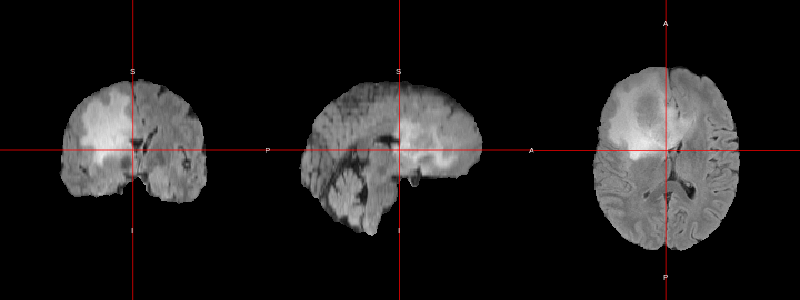

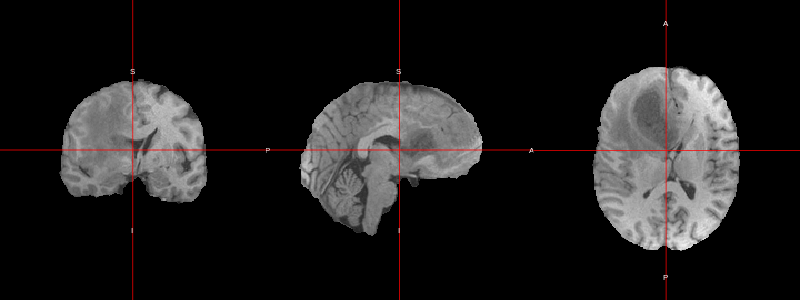

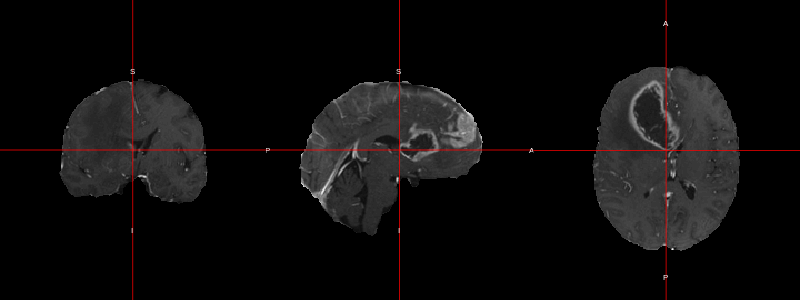

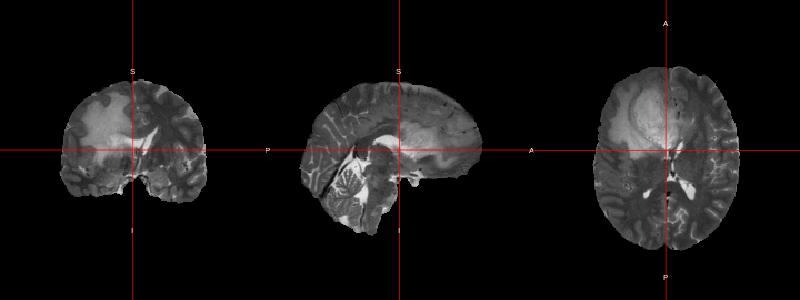

In [ ]:
%%R -i img -w 800 -h 300 -u px

library(neurobase)
ortho2(img[1,,,], mfrow=c(1,3))
ortho2(img[2,,,], mfrow=c(1,3))
ortho2(img[3,,,], mfrow=c(1,3))
ortho2(img[4,,,], mfrow=c(1,3))

***
## Calculate mean and standard deviation for each channel

In [ ]:
means = np.zeros((len(dataset), 4))
stds  = np.zeros((len(dataset), 4))
means_brain = np.zeros((len(dataset), 4))
stds_brain  = np.zeros((len(dataset), 4))
for i, (data, _) in enumerate(tqdm(dataset)):
    data = data.asnumpy()
    #import pdb; pdb.set_trace()
    means[i,] = data.mean(axis=(1,2,3))
    stds[i,]  = data.std(axis=(1,2,3))
    means_brain[i,] = [data[i,][data[i,]!=0].mean() for i in range(len(data))]
    stds_brain[i,]  = [data[i,][data[i,]!=0].std() for i in range(len(data))]

In [ ]:
means.shape

In [ ]:
means[0:5]


[[  56.3145     59.84573    69.92895    19.383139]
 [1998.7661   3222.0166    928.2562   1023.20355 ]
 [  31.252329   57.07835    62.944374   27.433558]
 [  21.099354   52.989193   58.160217   63.534687]
 [1673.3604    301.92923  1056.7434    109.46807 ]]
<NDArray 5x4 @cpu(0)>

In [ ]:
stds[0:5]


[[ 130.07066   138.5119    165.58444    47.049816]
 [4662.2095   7283.09     2231.2769   2641.809   ]
 [  72.384964  128.39795   141.77567    65.835526]
 [  48.26763   118.698135  129.40108   148.4802  ]
 [4093.1006    730.0079   2565.0227    260.89902 ]]
<NDArray 5x4 @cpu(0)>

In [ ]:
means_brain[0:5]


[[  339.7907     361.09753    421.93762    116.954155]
 [11859.168    19110.395     5505.6636    6071.094   ]
 [  176.2342     321.84174    354.91797    154.72408 ]
 [  119.89242    301.09924    330.48288    361.02173 ]
 [10675.427     1926.197     6741.636      698.36597 ]]
<NDArray 5x4 @cpu(0)>

In [ ]:
stds_brain[0:5]


[[  75.88576    83.545044  130.04083    44.10836 ]
 [3468.2944   3312.729    2080.215    3280.8374  ]
 [  63.213596   88.01173    98.54435    68.92459 ]
 [  37.33251    73.16446    71.76831   133.69878 ]
 [3283.389     520.72345  1910.0692    151.60114 ]]
<NDArray 5x4 @cpu(0)>

In [ ]:
np.savez_compressed('../data/normalization_stats_' + split + '.npz', 
                    means       = means, 
                    stds        = stds, 
                    means_brain = means_brain, 
                    stds_brain  = stds_brain)

***
## Confirm normalization

### Load example subject

In [ ]:
data = np.load('../data/normalization_stats_' + split + '.npz')
means       = nd.array(data['means'])
stds        = nd.array(data['stds'])
means_brain = nd.array(data['means_brain'])
stds_brain  = nd.array(data['stds_brain'])

In [ ]:
def transform(img, means, stds):
    means = means.reshape(-1,1,1,1)
    stds  = stds.reshape(-1,1,1,1)
    return (img - means) / stds

In [ ]:
dataset = MRISegDataset(root=data_dir, split=split, mode='val', crop_size=crop_size, transform=transform, means=means, stds=stds)

In [ ]:
data = dataset[0][0].asnumpy()

### Calculate `mean` and `std`

(Should be `mean=0`, `std=1`)

In [ ]:
[data[i,].mean() for i in range(len(data))]

In [ ]:
[data[i,].std() for i in range(len(data))]

***
## Plot after normalization

In [ ]:
dataset = MRISegDataset(root=data_dir, split=split, mode='val', crop_size=crop_size, transform=transform, means=means_brain, stds=stds_brain)

In [ ]:
img, mask = dataset[0]
img = img.asnumpy()

In [ ]:
%%R -i img -w 800 -h 300 -u px

library(neurobase)
ortho2(img[1,,,], mfrow=c(1,3), window=c(-4,4))
ortho2(img[2,,,], mfrow=c(1,3), window=c(-4,4))
ortho2(img[3,,,], mfrow=c(1,3), window=c(-4,4))
ortho2(img[4,,,], mfrow=c(1,3), window=c(-4,4))